In [2]:
import numpy as np
from tqdm.auto import trange
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.utils as vutils

In [3]:
device = torch.device('cuda')

IMG_SIZE = 32
BATCH_SIZE = 128
timesteps = 16
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 48186686.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
def convertImage(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def forward_noise(x, t):
    a = time_bar[t]
    b = time_bar[t + 1]

    noise = np.random.normal(size=x.shape)
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

t = generate_ts(25)
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)

In [5]:
class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.dense_ts = nn.Linear(192, 128)
        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))
        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter
        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))
        return x_out

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )

        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)

        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),
            nn.Linear(128, 32 * 4 * 4),
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )

        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)

        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)

        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)

    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)

        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)

        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)

        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]

        for i, block in enumerate(blocks):
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)
            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = self.cnn_output(x)
        return x

In [66]:
losses=[]
model = Model().to(device)

epochs=30
def train():
    bar = trange(epochs)
    total = len(trainloader)
    for i in bar:
      epoch_loss=0.0
      for j, (x_img, _) in enumerate(trainloader):
        x_ts = generate_ts(len(x_img))
        x_a, x_b = forward_noise(x_img, x_ts)

        x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
        x_a = x_a.float().to(device)
        x_b = x_b.float().to(device)

        y_p = model(x_a, x_ts)
        loss = torch.mean(torch.abs(y_p - x_b))
        model.opt.zero_grad()
        loss.backward()
        model.opt.step()
        loss = loss.item()
        epoch_loss+=loss
        pg = (j / total) * 100
        if j % 5 == 0:
          bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')
      avg_epoch_loss = epoch_loss / total
      losses.append(avg_epoch_loss)
      print(f'Epoch {i + 1}/{epochs}, Average Loss: {avg_epoch_loss:.5f}')

train()
# Save the trained model
torch.save(model.state_dict(), "diffusion_model.pth")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Average Loss: 0.07956
Epoch 2/30, Average Loss: 0.03283
Epoch 3/30, Average Loss: 0.03033
Epoch 4/30, Average Loss: 0.02904
Epoch 5/30, Average Loss: 0.02752
Epoch 6/30, Average Loss: 0.02673
Epoch 7/30, Average Loss: 0.02574
Epoch 8/30, Average Loss: 0.02496
Epoch 9/30, Average Loss: 0.02453
Epoch 10/30, Average Loss: 0.02425
Epoch 11/30, Average Loss: 0.02389
Epoch 12/30, Average Loss: 0.02342
Epoch 13/30, Average Loss: 0.02322
Epoch 14/30, Average Loss: 0.02305
Epoch 15/30, Average Loss: 0.02290
Epoch 16/30, Average Loss: 0.02273
Epoch 17/30, Average Loss: 0.02263
Epoch 18/30, Average Loss: 0.02243
Epoch 19/30, Average Loss: 0.02244
Epoch 20/30, Average Loss: 0.02230
Epoch 21/30, Average Loss: 0.02208
Epoch 22/30, Average Loss: 0.02211
Epoch 23/30, Average Loss: 0.02204
Epoch 24/30, Average Loss: 0.02197
Epoch 25/30, Average Loss: 0.02178
Epoch 26/30, Average Loss: 0.02184
Epoch 27/30, Average Loss: 0.02163
Epoch 28/30, Average Loss: 0.02169
Epoch 29/30, Average Loss: 0.

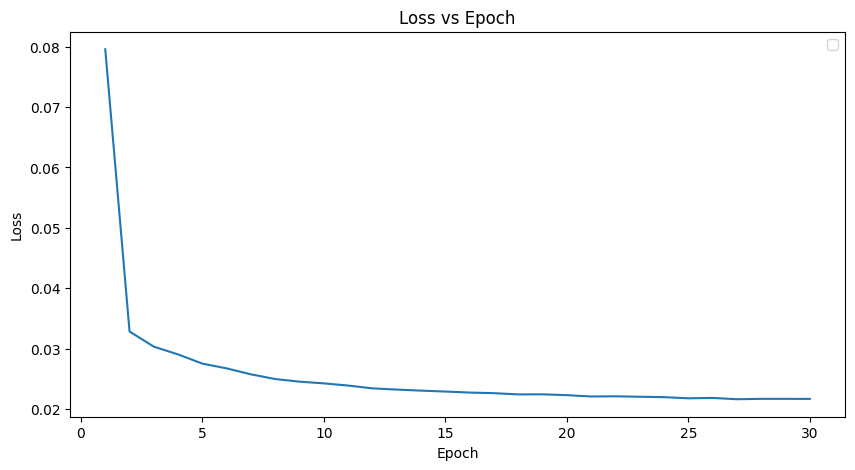

In [67]:
# Plot the Loss vs Epoch curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [68]:
model.load_state_dict(torch.load("diffusion_model.pth"))
model.eval()
generated_images=[]

def generate_images(cnt):
    xs = []
    x = torch.randn(size=(8, 3, IMG_SIZE, IMG_SIZE), device=device)

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = convertImage(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        if i==len(xs)-1:
          generated_images.append(torch.tensor(xs[i]).unsqueeze(0).permute(0,3,2,1))
          vutils.save_image(torch.tensor(xs[i]).unsqueeze(0).permute(0,3,2,1), f"diffusion_generated_image_{cnt+1}.png", normalize=True)
          cnt=cnt+1
        plt.axis('off')

  0%|          | 0/16 [00:00<?, ?it/s]

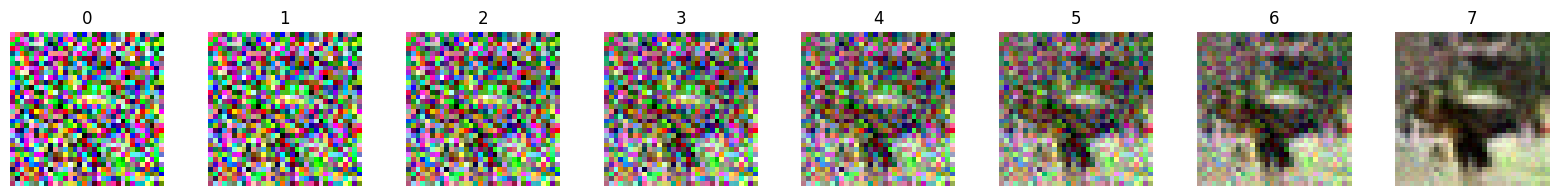

  0%|          | 0/16 [00:00<?, ?it/s]

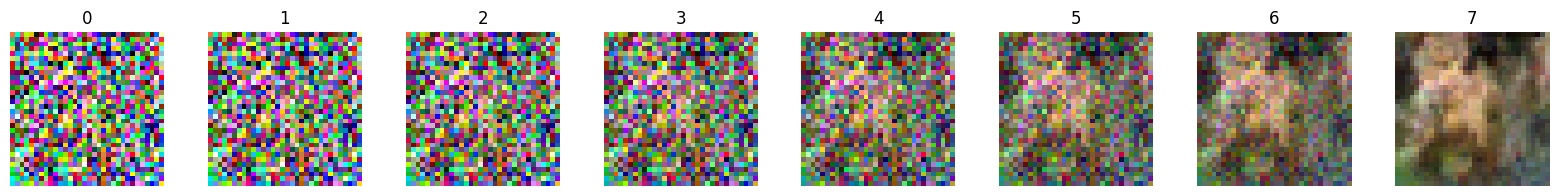

  0%|          | 0/16 [00:00<?, ?it/s]

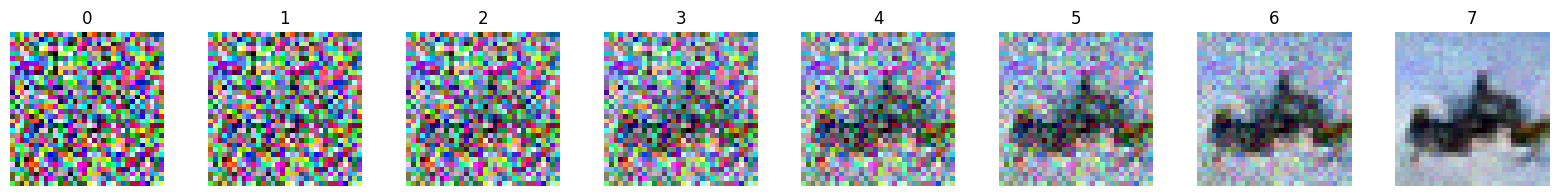

  0%|          | 0/16 [00:00<?, ?it/s]

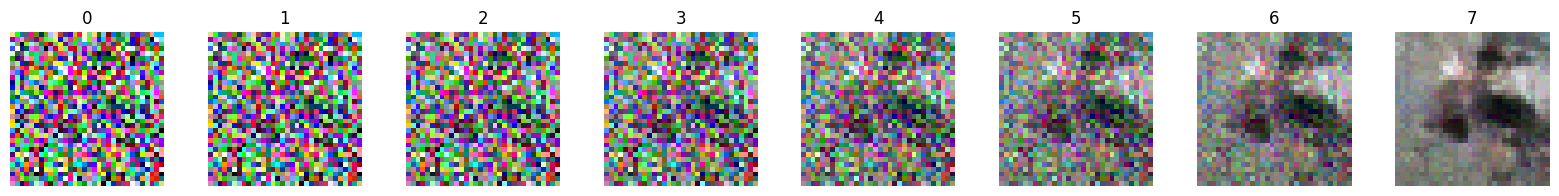

  0%|          | 0/16 [00:00<?, ?it/s]

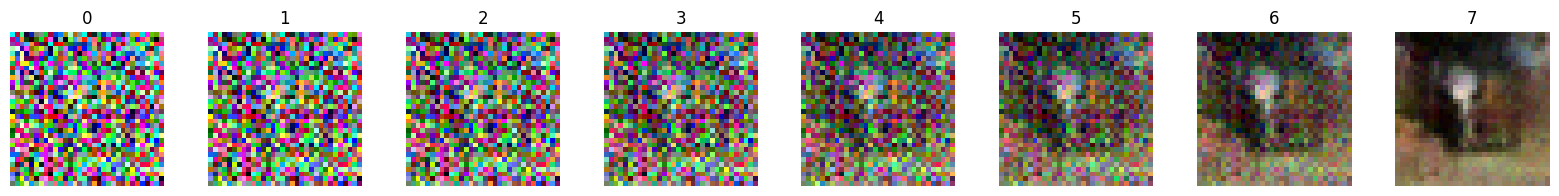

  0%|          | 0/16 [00:00<?, ?it/s]

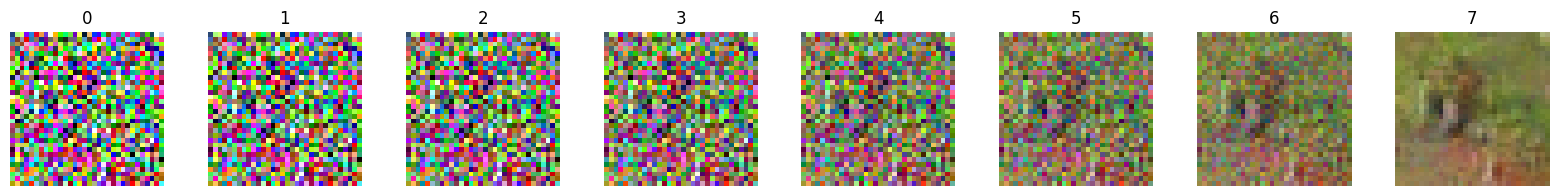

  0%|          | 0/16 [00:00<?, ?it/s]

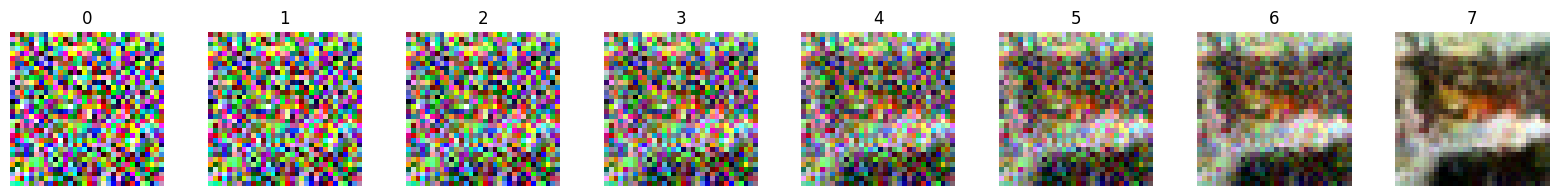

  0%|          | 0/16 [00:00<?, ?it/s]

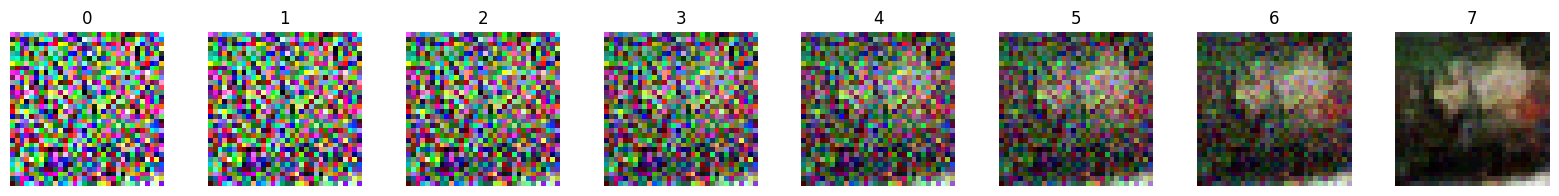

  0%|          | 0/16 [00:00<?, ?it/s]

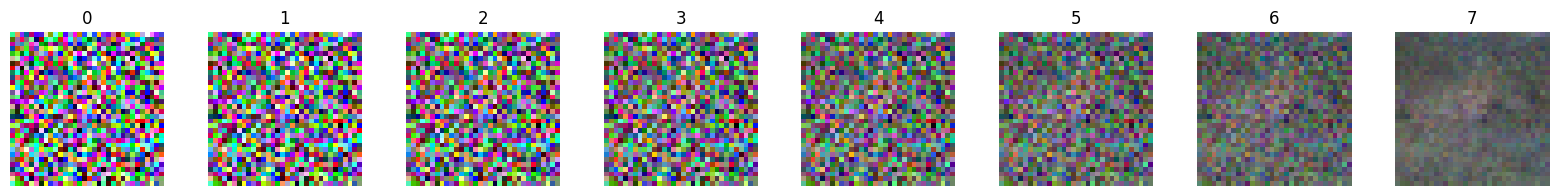

  0%|          | 0/16 [00:00<?, ?it/s]

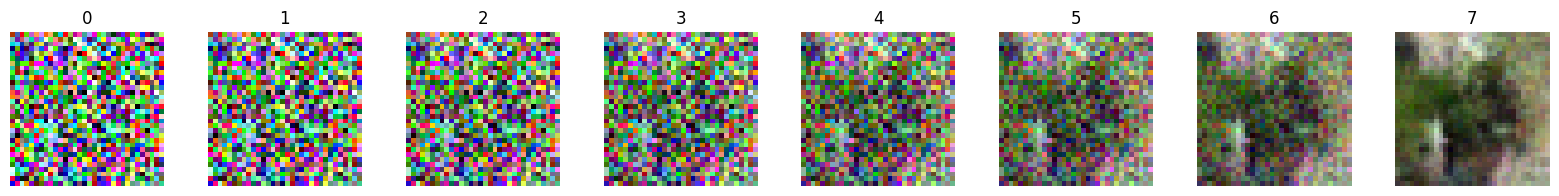

In [69]:
num_images_to_generate = 10
for i in range(num_images_to_generate):
    for pg in model.opt.param_groups:
        pg['lr'] = max(0.000001, pg['lr'] * 0.9)

    generate_images(i)
    plt.show()

In [70]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=20, resize=False, splits=1):
    N = len(imgs)

    assert batch_size > 0

    assert N == batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    imgs_tensor = torch.cat(imgs, dim=0).type(dtype)
    dataloader = torch.utils.data.DataLoader(imgs_tensor, batch_size=batch_size)
    inception_model = models.inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batchv = Variable(batch)

        preds[i * batch_size:i * batch_size + batch_size] = get_pred(batchv)

    # compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


print("Calculating Inception Score...")
print(inception_score(generated_images, cuda=True, batch_size=10, resize=True, splits=1))

Calculating Inception Score...
(2.211635888615484, 0.0)


## Architecture used

### Temporal Embedding Module:

- Linear layer with 1 input channel (for time steps) and 192 output channels.
- Layer normalization with 192 channels.
- ReLU activation.
- Downsampling Blocks

### Each downsampling block (Block) consists of:
- Convolutional layer with 3x3 kernel, 128 input channels, and 128 output channels, followed by ReLU activation.
- Linear layer with 192 input features and 128 output features, followed by ReLU activation.
- Element-wise multiplication of the convolutional output and the temporal embedding.
- Convolutional layer with 3x3 kernel, 128 input channels, and 128 output channels.
- Element-wise addition of the output of the previous convolutional layer and the result of the multiplication.
- ReLU activation.
- Layer normalization with 128 channels.

### MLP Module:

- Linear layer with input features and 128 output features, followed by Layer Normalization and ReLU activation.
- Linear layer with 128 input features and output features followed by Layer Normalization and ReLU activation.


### Upsampling Blocks 

- Each upsampling block (Block) follows a similar structure as the downsampling block, but with the addition of upsampling using bilinear interpolation before each block.

### Final Convolutional Layer 
- Convolutional layer with 1x1 kernel, 128 input channels, and 3 output channels

### Optimizer (self.opt):
- Adam optimizer with a learning rate of 0.0008.


## Inception score:
- Inception score of DC-GAN is better in comparison to Diffusion model